In [1]:
from fenics import *
from ufl import nabla_div
import numpy as np
import matplotlib.pyplot as plt
from fenicsadapter import *
%matplotlib inline

In [29]:
# Dimensionless Geometry and material properties
d=2 #number of dimensions
H = 1
W = 0.3
rho = 0.02
E=1000.0
nu= 0.3

mu    = Constant(E / (2.0*(1.0 + nu)))

lambda_ = Constant(E*nu / ((1.0 + nu)*(1.0 - 2.0*nu)))

# create Mesh
mesh = RectangleMesh(Point(0,0), Point(W,H), 3,10)

#create Function Space
V = VectorFunctionSpace(mesh, 'P', 2)

#BCs
tol=1E-14

def clamped_boundary(x, on_boundary):
    return on_boundary and abs(x[1])<tol

def Neumann_Boundary(x,on_boundary):
    return on_boundary and not(abs(x[1]<tol))

In [ ]:
# initialize the adapter
adapter_config_filename = "precice-adapter-config-fsi-s.json"
precice = Adapter(adapter_config_filename)

precice_dt = precice.initialize(coupling_subdomain=Neumann_Boundary, 
                                mesh=mesh,
                                read_field=f_N_function,
                                write_field=u_D_function,
                                u_n=u_n)
# 

In [30]:
#alpha method parameters

alpha_m = Constant(0.2)
alpha_f = Constant(0.4)
gamma   = Constant(0.5+alpha_f-alpha_m)
beta    = Constant((gamma+0.5)**2/4.)

In [42]:
#parameters for Time-Stepping
T = 1.0
Nsteps = 80
dt = Constant(T/Nsteps)

In [43]:
#Loading by an Expression: sinus loading dependend on x_0
#p = Expression(('1*sin(2*pi*t) * x[0]','0'),degree=1, t=0)
p = Expression( ('t<1 ? 0.01 : 0.01','0'),degree=1, t=0)

In [44]:
# Trial and Test Functions
du = TrialFunction(V)
v = TestFunction(V)

u = Function(V)

# function known from previous timestep
u_old = Function(V)
v_old = Function(V)
a_old = Function(V)

In [45]:
# Maybe there should be some BCs here that i don't understand yet
boundary_subdomains = MeshFunction("size_t", 
                                   mesh, mesh.topology().dim()-1)
boundary_subdomains.set_all(0)
force_boundary = AutoSubDomain(Neumann_Boundary)
force_boundary.mark(boundary_subdomains, 3)

#Define measure for boundary conditions integral
dss=ds(subdomain_data=boundary_subdomains)


# clamp the beam at the bottom
bc = DirichletBC(V, Constant((0,0)), clamped_boundary)


In [46]:
#Define strain 
def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)

# Define Stress tensor
def sigma(u):
    return lambda_*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)

# Define Mass form
def m(u,v):
    return rho*inner(u,v)*dx

# Elastic stiffness form
def k(u,v):
    return inner(sigma(u), sym(grad(v))) * dx

# External Work
def Wext(u_):
    return dot(u_,p)*dss(3)

In [47]:
# Update functions

# Update accelleration
def update_a(u, u_old,v_old, a_old, ufl=True):
    if ufl:
        dt_=dt
        beta_=beta
    else:
        dt_=float(dt)
        beta_=float(beta)
    
    return ((u - u_old - dt_*v_old)/beta/dt_**2 
            - (1-2*beta_)/2/beta_*a_old)

# Update velocity
def update_v(a,u_old,v_old,a_old, ufl = True):
    if ufl:
        dt_=dt
        gamma_=gamma
    else:
        dt_=float(dt)
        gamma_=float(gamma)
    
    return v_old + dt_*((1-gamma_)*a_old + gamma_*a)

def update_fields(u, u_old, v_old, a_old):
    '''Update all fields at the end of a timestep.'''
    
    u_vec, u0_vec = u.vector(), u_old.vector()
    v0_vec, a0_vec = v_old.vector(), a_old.vector()
    
    #call update functions
    a_vec = update_a(u_vec, u0_vec, v0_vec, a0_vec, ufl=False)
    v_vec = update_v(a_vec, u0_vec, v0_vec, a0_vec, ufl=False)
    
    #assign u->u_old
    v_old.vector()[:], a_old.vector()[:] = v_vec, a_vec
    u_old.vector()[:] = u.vector()

In [48]:
def avg(x_old, x_new, alpha):
    return alpha*x_old + (1-alpha)*x_new

# residual
a_new = update_a(du, u_old, v_old, a_old, ufl=True)
v_new = update_a(a_new, u_old, v_old, a_old, ufl=True)

res = m(avg(a_old,a_new,alpha_m), v) \
+ k(avg(u_old,du, alpha_f), v) - Wext(v)

a_form= lhs(res)
L_form= rhs(res)


In [49]:
#optional precomputation of LU decomposition of K

In [50]:
# Prepare for time-stepping
time = np.linspace(0,T,Nsteps+1)
u_tip = np.zeros((Nsteps+1,1))
E_ext = 0

In [51]:
#time loop
for n in range(Nsteps):
    
    t=time[n+1]
    print("Time:",t)
    
    #evaluate Force field at alpha_f-average
    p.t=t-float(alpha_f*dt)
    
    #solve for new displacements
    solve(a_form==L_form, u, bc)
    
    update_fields(u, u_old, v_old, a_old)
    
    p.t=t
    
    u_tip[n+1] = u(0.1,1.)[0]
    
    
    

Time: 0.0125
Time: 0.025
Time: 0.037500000000000006
Time: 0.05
Time: 0.0625
Time: 0.07500000000000001
Time: 0.08750000000000001
Time: 0.1
Time: 0.1125
Time: 0.125
Time: 0.1375
Time: 0.15000000000000002
Time: 0.1625
Time: 0.17500000000000002
Time: 0.1875
Time: 0.2
Time: 0.21250000000000002
Time: 0.225
Time: 0.23750000000000002
Time: 0.25
Time: 0.2625
Time: 0.275
Time: 0.28750000000000003
Time: 0.30000000000000004
Time: 0.3125
Time: 0.325
Time: 0.3375
Time: 0.35000000000000003
Time: 0.36250000000000004
Time: 0.375
Time: 0.3875
Time: 0.4
Time: 0.41250000000000003
Time: 0.42500000000000004
Time: 0.4375
Time: 0.45
Time: 0.4625
Time: 0.47500000000000003
Time: 0.48750000000000004
Time: 0.5
Time: 0.5125000000000001
Time: 0.525
Time: 0.5375
Time: 0.55
Time: 0.5625
Time: 0.5750000000000001
Time: 0.5875
Time: 0.6000000000000001
Time: 0.6125
Time: 0.625
Time: 0.6375000000000001
Time: 0.65
Time: 0.6625000000000001
Time: 0.675
Time: 0.6875
Time: 0.7000000000000001
Time: 0.7125
Time: 0.72500000000000

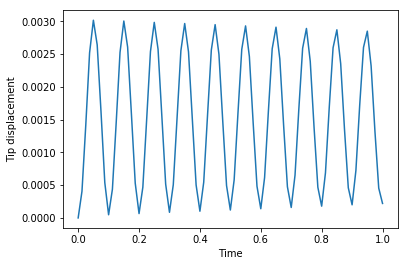

In [52]:
# Plot tip displacement evolution
plt.figure()
plt.plot(time, u_tip)
plt.xlabel("Time")
plt.ylabel("Tip displacement")
plt.show()